In [25]:
from utils.feature_utils import ParameterNormalizer, get_condition_aware_labels
import pandas as pd
import seaborn as sns

# Example configuration for your parameters
normalization_configs = {}
filename = f"./data/wmh_6s3a/500a_12b_78t_wmh_no_switch_alow.csv"
print(filename)
df = pd.read_csv(filename)
shared, conditioned = ['wm_bias', 'stickiness', 'phi', 'eps', 'alpha', 'eta6_wm'], []#, 'eta2_wm'
for p in shared:
    if p in ['alpha', 'phi', 'eps']:
        normalization_configs[p] = {
            'method': 'log_standard',
            'range': (0, 1),
            'is_skewed': True
        }
    elif p in ['stickiness']:
        normalization_configs[p] = {
            'method': 'standard',
            'range': (-1, 1),
            'is_skewed': False
        }
    else:
        normalization_configs[p] = {
            'method': 'standard',
            'range': (0, 1),
            'is_skewed': False
        }

train_labels = get_condition_aware_labels(df, shared, conditioned)

./data/wmh_6s3a/500a_12b_78t_wmh_no_switch_alow.csv


<Axes: ylabel='Count'>

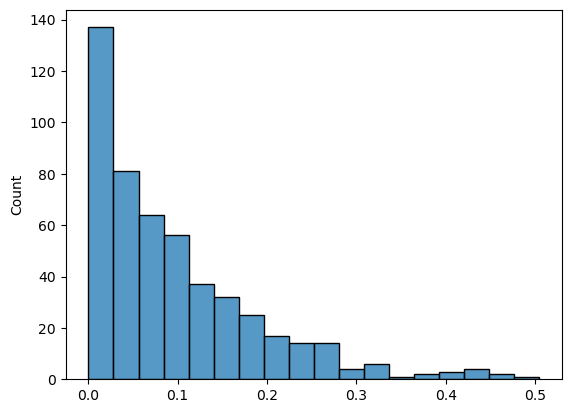

In [28]:
a = ParameterNormalizer(normalization_configs)
vdf = a.fit_transform(train_labels)
sns.histplot(a.inverse_transform(vdf)['eps'])

In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import GRU, Dense, Dropout
from tensorflow.keras.optimizers import Adam

def create_generic_multi_output_gru_model(
    feature_dim: int,
    parameter_configs: dict,
    units: int = 70,
    dropout: float = 0.2,
    dropout1: float = 0.2,
    dropout2: float = 0.1,
    learning_rate: float = 3e-4
):
    """
    Create a generic multi-output GRU model with custom losses for multiple parameters.
    
    Args:
        feature_dim: Input feature dimension
        parameter_configs: Dictionary defining each parameter to predict
            Format: {
                'param_name': {
                    'dims': int,                    # Number of dimensions for this parameter
                    'loss_type': str,              # 'mse', 'log_mse', 'weighted_mse', 'mae', 'huber', custom_function
                    'loss_weight': float,          # Weight for this parameter in combined loss
                    'activation': str,             # 'linear', 'softplus', 'sigmoid', 'relu', etc.
                    'loss_params': dict            # Optional: additional parameters for loss function
                }
            }
        units: Number of GRU units
        dropout: Dropout rates for different layers
        learning_rate: Learning rate for optimizer
    
    Example parameter_configs:
        {
            'alpha': {
                'dims': 2,
                'loss_type': 'log_mse',
                'loss_weight': 2.0,
                'activation': 'softplus',
                'loss_params': {'epsilon': 1e-8}
            },
            'stickiness': {
                'dims': 1,
                'loss_type': 'mse',
                'loss_weight': 1.0,
                'activation': 'linear'
            },
            'learning_rate_param': {
                'dims': 1,
                'loss_type': 'weighted_mse',
                'loss_weight': 1.5,
                'activation': 'sigmoid',
                'loss_params': {'weight_factor': 3.0}
            }
        }
    """
    
    # Define custom loss functions
    def log_mse_loss(epsilon=1e-8):
        """Log-transformed MSE loss for skewed data"""
        def loss_fn(y_true, y_pred):
            log_true = tf.math.log(y_true + epsilon)
            log_pred = tf.math.log(y_pred + epsilon)
            return tf.reduce_mean(tf.square(log_true - log_pred))
        return loss_fn
    
    def weighted_mse_loss(weight_factor=2.0, min_weight=0.1, max_weight=10.0):
        """Weighted MSE that gives more weight to smaller values"""
        def loss_fn(y_true, y_pred):
            weights = 1.0 / (y_true + 1e-8) * weight_factor
            weights = tf.clip_by_value(weights, min_weight, max_weight)
            mse = tf.square(y_true - y_pred)
            return tf.reduce_mean(weights * mse)
        return loss_fn
    
    def huber_loss(delta=1.0):
        """Huber loss - robust to outliers"""
        def loss_fn(y_true, y_pred):
            error = y_true - y_pred
            is_small_error = tf.abs(error) <= delta
            squared_loss = tf.square(error) / 2
            linear_loss = delta * tf.abs(error) - tf.square(delta) / 2
            return tf.reduce_mean(
                tf.where(is_small_error, squared_loss, linear_loss)
            )
        return loss_fn
    
    # Validate parameter configs
    if not parameter_configs:
        raise ValueError("parameter_configs cannot be empty")
    
    for param_name, config in parameter_configs.items():
        required_keys = ['dims', 'loss_type', 'loss_weight', 'activation']
        for key in required_keys:
            if key not in config:
                raise ValueError(f"Missing required key '{key}' for parameter '{param_name}'")
    
    # Input layer
    encoder_inputs = layers.Input(shape=(None, feature_dim))
    
    # Shared encoder
    encoder = GRU(units, return_state=False, return_sequences=False)
    encoder_outputs = encoder(encoder_inputs)
    encoder_outputs = Dropout(dropout)(encoder_outputs)
    
    # Shared dense layers
    shared_dense = Dense(int(units/2), activation='relu')(encoder_outputs)
    shared_dense = Dropout(dropout1)(shared_dense)
    shared_dense = Dense(int(units/4), activation='relu')(shared_dense)
    shared_dense = Dropout(dropout2)(shared_dense)
    
    # Create output heads dynamically
    outputs = {}
    loss_dict = {}
    loss_weights = {}
    
    for param_name, config in parameter_configs.items():
        # Create output head
        output_name = f"{param_name}_output"
        param_output = Dense(
            config['dims'], 
            activation=config['activation'], 
            name=output_name
        )(shared_dense)
        outputs[output_name] = param_output
        
        # Configure loss function
        loss_type = config['loss_type']
        loss_params = config.get('loss_params', {})
        
        if loss_type == 'log_mse':
            loss_dict[output_name] = log_mse_loss(**loss_params)
        elif loss_type == 'weighted_mse':
            loss_dict[output_name] = weighted_mse_loss(**loss_params)
        elif loss_type == 'huber':
            loss_dict[output_name] = huber_loss(**loss_params)
        elif loss_type in ['mse', 'mae', 'binary_crossentropy', 'categorical_crossentropy']:
            loss_dict[output_name] = loss_type
        elif callable(loss_type):
            # Custom loss function provided
            loss_dict[output_name] = loss_type
        else:
            raise ValueError(f"Unsupported loss_type '{loss_type}' for parameter '{param_name}'")
        
        # Set loss weight
        loss_weights[output_name] = config['loss_weight']
    
    # Create model
    model = keras.Model(inputs=encoder_inputs, outputs=outputs)
    
    # Compile model
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss=loss_dict,
        loss_weights=loss_weights
    )
    
    return model

# Convenience function for common parameter types
def create_parameter_config(param_type, dims, loss_weight=1.0, **kwargs):
    """
    Convenience function to create parameter configurations for common types.
    
    Args:
        param_type: 'skewed_positive', 'uniform', 'bounded', 'probability'
        dims: Number of dimensions
        loss_weight: Weight for this parameter
        **kwargs: Additional parameters specific to the type
    """
    
    config_templates = {
        'skewed_positive': {  # For parameters like alpha that are positive and skewed toward 0
            'dims': dims,
            'loss_type': 'log_mse',
            'loss_weight': loss_weight,
            'activation': 'softplus',
            'loss_params': {'epsilon': kwargs.get('epsilon', 1e-8)}
        },
        'uniform': {  # For parameters with uniform distribution
            'dims': dims,
            'loss_type': 'mse',
            'loss_weight': loss_weight,
            'activation': 'linear'
        },
        'bounded': {  # For parameters bounded between 0 and 1
            'dims': dims,
            'loss_type': 'mse',
            'loss_weight': loss_weight,
            'activation': 'sigmoid'
        },
        'probability': {  # For probability parameters
            'dims': dims,
            'loss_type': 'binary_crossentropy' if dims == 1 else 'categorical_crossentropy',
            'loss_weight': loss_weight,
            'activation': 'sigmoid' if dims == 1 else 'softmax'
        },
        'robust': {  # For parameters that might have outliers
            'dims': dims,
            'loss_type': 'huber',
            'loss_weight': loss_weight,
            'activation': 'linear',
            'loss_params': {'delta': kwargs.get('delta', 1.0)}
        }
    }
    
    if param_type not in config_templates:
        raise ValueError(f"Unknown parameter type: {param_type}")
    
    return config_templates[param_type]

# Usage examples
def example_usage():
    """Examples of how to use the generic multi-output model"""
    
    # Example 1: Manual configuration
    parameter_configs = {
        'alpha': {
            'dims': 2,
            'loss_type': 'log_mse',
            'loss_weight': 2.0,
            'activation': 'softplus',
            'loss_params': {'epsilon': 1e-8}
        },
        'stickiness': {
            'dims': 1,
            'loss_type': 'mse',
            'loss_weight': 1.0,
            'activation': 'linear'
        },
        'learning_rate_param': {
            'dims': 1,
            'loss_type': 'weighted_mse',
            'loss_weight': 1.5,
            'activation': 'sigmoid',
            'loss_params': {'weight_factor': 3.0}
        },
        'choice_probability': {
            'dims': 2,
            'loss_type': 'categorical_crossentropy',
            'loss_weight': 1.0,
            'activation': 'softmax'
        }
    }
    
    model1 = create_generic_multi_output_gru_model(
        feature_dim=10,
        parameter_configs=parameter_configs
    )
    
    # Example 2: Using convenience function
    parameter_configs_easy = {
        'alpha': create_parameter_config('skewed_positive', dims=2, loss_weight=2.0),
        'stickiness': create_parameter_config('uniform', dims=1, loss_weight=1.0),
        'choice_prob': create_parameter_config('probability', dims=2, loss_weight=1.0),
        'bounded_param': create_parameter_config('bounded', dims=1, loss_weight=1.5)
    }
    
    model2 = create_generic_multi_output_gru_model(
        feature_dim=10,
        parameter_configs=parameter_configs_easy
    )
    
    return model1, model2

# Helper function to prepare training data
def prepare_multi_output_data(X, **parameter_arrays):
    """
    Prepare training data for multi-output model.
    
    Args:
        X: Input features
        **parameter_arrays: Named arrays for each parameter (e.g., alpha=alpha_array, stickiness=stickiness_array)
    
    Returns:
        Tuple of (X, y_dict) where y_dict has keys like 'param_name_output'
    """
    y_dict = {}
    for param_name, param_data in parameter_arrays.items():
        y_dict[f"{param_name}_output"] = param_data
    
    return X, y_dict

In [12]:
"""Example of how to train the model"""
import numpy as np

# Create dummy data
n_samples, seq_length, feature_dim = 1000, 20, 10
X = np.random.randn(n_samples, seq_length, feature_dim)

# Target parameters
alpha_targets = np.random.exponential(0.5, (n_samples, 1))  # Skewed positive
stickiness_targets = np.random.uniform(0, 1, (n_samples, 1))  # Uniform

# Prepare data
X_train, y_train = prepare_multi_output_data(
    X, 
    alpha=alpha_targets, 
    stickiness=stickiness_targets
)
print(X_train.shape)
# Create model
parameter_configs = {
    'alpha': create_parameter_config('skewed_positive', dims=1, loss_weight=2.0),
    'stickiness': create_parameter_config('uniform', dims=1, loss_weight=1.0)
}

model = create_generic_multi_output_gru_model(
    feature_dim=feature_dim,
    parameter_configs=parameter_configs
)

# Train
history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)

2025-06-25 13:37:12.939481: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2025-06-25 13:37:12.940024: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2025-06-25 13:37:12.940969: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

(1000, 20, 10)
Epoch 1/10


2025-06-25 13:37:13.078363: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2025-06-25 13:37:13.079202: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2025-06-25 13:37:13.079976: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

25/25 [==============================] - 1s 14ms/step - loss: 6.3247 - alpha_output_loss: 3.0320 - stickiness_output_loss: 0.2606 - val_loss: 6.2578 - val_alpha_output_loss: 3.0397 - val_stickiness_output_loss: 0.1784
Epoch 2/10
14/25 [===============>..............] - ETA: 0s - loss: 6.0952 - alpha_output_loss: 2.9477 - stickiness_output_loss: 0.1998

2025-06-25 13:37:14.151911: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2025-06-25 13:37:14.152847: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2025-06-25 13:37:14.153443: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

25/25 [==============================] - 0s 5ms/step - loss: 5.8130 - alpha_output_loss: 2.8130 - stickiness_output_loss: 0.1870 - val_loss: 5.8473 - val_alpha_output_loss: 2.8583 - val_stickiness_output_loss: 0.1308
Epoch 3/10
25/25 [==============================] - 0s 6ms/step - loss: 5.4331 - alpha_output_loss: 2.6424 - stickiness_output_loss: 0.1482 - val_loss: 5.4050 - val_alpha_output_loss: 2.6486 - val_stickiness_output_loss: 0.1077
Epoch 4/10
25/25 [==============================] - 0s 5ms/step - loss: 5.0684 - alpha_output_loss: 2.4631 - stickiness_output_loss: 0.1422 - val_loss: 4.9110 - val_alpha_output_loss: 2.4024 - val_stickiness_output_loss: 0.1063
Epoch 5/10
25/25 [==============================] - 0s 5ms/step - loss: 4.6282 - alpha_output_loss: 2.2439 - stickiness_output_loss: 0.1405 - val_loss: 4.3725 - val_alpha_output_loss: 2.1293 - val_stickiness_output_loss: 0.1139
Epoch 6/10
25/25 [==============================] - 0s 5ms/step - loss: 4.2813 - alpha_output_loss:

In [15]:
for k, v in y_train.items():
    print(k, v.shape)

alpha_output (1000, 1)
stickiness_output (1000, 1)


<Axes: ylabel='Count'>

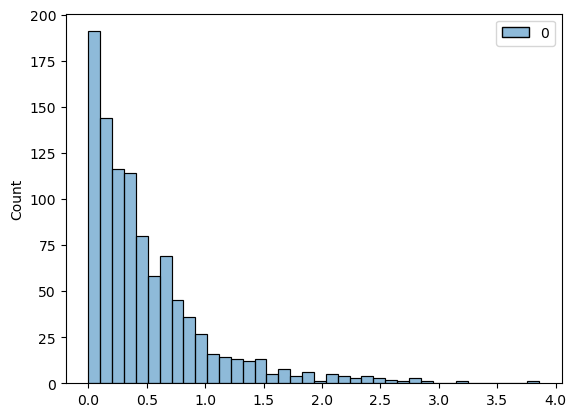

In [10]:
import seaborn as sns
import numpy as np

sns.histplot(alpha_targets)